In [1]:
%pylab notebook

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from copy import deepcopy
import secrets
import os

import primo.models
import primo.datasets
import primo.tools.sequences as seqtools
from primo.models.cas9_keras import log_multisite_predictor

# Enable memory growth so that we only use as much GPU memory as needed.
# By default, tensorflow will reserve nearly all of the GPU memory.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0l2pbq7d because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib
1 Physical GPUs, 1 Logical GPUs


In [2]:
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=5*10**4
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

# To see how this value was derived, please consult the Materials and Methods subsection under 
# Feature Extraction section in Bee et. al. 2021. 
similarity_threshold = 75
# Intuitively determined:
batch_size = 20
val_batch_size = 150

def keras_batch_generator(dataset_batch_generator):
    # Yield datasets
    # Each sample is a triplet with known similar and dissimilar images, so the y_true
    # value is unused in the loss function.
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by
        #   enumerating all the images in the dataset (before splitting them into 
        #   test/train/validate datasets)
        # triplets: A set of three image feature vectos containing anchor, positive (similar) 
        #   image, and negative (dissimilar) image
        indices, triplets = next(dataset_batch_generator)
        yield triplets, np.zeros(len(triplets))

train_batch_generator = keras_batch_generator(
    primo.datasets.dataset.triplet_batch_generator(
        train_dataset.random_features(batch_size),
        similarity_threshold
    )
)

val_batch_generator = keras_batch_generator(
    primo.datasets.dataset.triplet_batch_generator(
        validation_dataset.random_features(val_batch_size),
        similarity_threshold
    )
)

train_inputs, train_targets = next(train_batch_generator)

switching to train_b.h5 and train_7.h5


In [3]:
# The reason the default encoder input is a 4096-dimensional vector is
# because we're representing our images through an embedding that was learned
# by a computer vision model known as VGG [1]. We're borrowing the output of the
# 2nd fully-connected layer (i.e. the FC2), which spits out a 4096-by-1 vector.
#
# If you're very curious about VGG's innerworkings, you can see an example tensorflow
# implementation here [2, 3].
#
# Note for future users: If you ever decide to use a different model VGG16,
# you'd probably want to change the input dimension here.
#
# [1] - https://neurohive.io/en/popular-networks/vgg16/
# [2] - https://www.cs.toronto.edu/~frossard/post/vgg16/
# [3] - https://github.com/kentsommer/VGG16-Image-Retrieval/blob/master/vgg16_example.py#L237
INPUT_FEATURE_SIZE = 4096 

# Each CAS site is 20nt, so the output length should be 20nt for single
# site, and a multiple of 20nt for multiple sites.
OUTPUT_LEN = 80

# Temperature used for softmax calculation
SOFTMAX_TEMP = 1.0

# Optionally, load a previously saved model to continue training
MODEL_FILE=None

def hardmax(temperature):
    def hardmax_f(x):
        y = tf.nn.softmax(x / temperature)
        y_hard = tf.one_hot(tf.argmax(y, -1), 4)
        y = tf.stop_gradient(y_hard - y) + y
        return y
    return hardmax_f

# Create the keras model for a single encoder. This is instantiated three times in the
# model, but trained together -- they will all share a set of weights.
encoder = tf.keras.Sequential([
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0000)),
    layers.Dropout(0.2),
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0000)),
    layers.Dropout(0.2),
    layers.Dense(OUTPUT_LEN * 4, activation='relu'),
    layers.Reshape([OUTPUT_LEN, 4]),
    layers.Lambda(hardmax(SOFTMAX_TEMP)),
], name='encoder')

# Start with previously trained model if a filename is provided
if MODEL_FILE is not None:
    encoder = tf.keras.models.load_model(MODEL_FILE)

# First input is anchor, second is a positive sample, third is a negative sample
X_triplets = layers.Input([3, INPUT_FEATURE_SIZE])

# Essentially, we started with a batch of feature-vector triplets...
# ...And turned them into a triplet of feature-vector batches.
X1, X2, X3 = layers.Lambda(lambda X: (X[:,0,:], X[:,1,:], X[:,2,:]))(X_triplets)

# Layer to compute euclidean distances between the triplet pairs for convenience
distances = layers.Lambda(lambda Xs:
                          (
                              tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[1]), axis=1)),
                              tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[2]), axis=1))
                          ))([X1,X2,X3])

# Independently transforms the batches of feature vectors into one-hot encoded DNA sequences.
S1 = encoder(X1)
S2 = encoder(X2)
S3 = encoder(X3)

# Glue them back together! Back into a batch of feature vector triplets.
S_triplets = layers.Lambda(
    lambda Ss: tf.stack(Ss, axis=-1)
)([S1,S2,S3])

# Dimensions: (batch_size x 80 x 4 x 3 ) (i.e. batch size x DNA length x # of nucleotides x 3)
# Swaps dimensions for the loss function, which wants (batch-size x 3 x DNA length x 4)
S_triplets_T = layers.Lambda(lambda S: tf.transpose(S, [0, 3, 1, 2]))(S_triplets)

encoder_trainer = tf.keras.Model(inputs=X_triplets, outputs=S_triplets_T)

In [4]:
# Defined the loss function, and metrics used for training

def UniquenessMetric(y_true, y_pred):
    seqs = encoder_trainer(train_inputs)
    # Reduce seqs to a single base (e.g. [0.3, 0.1, 0.5, 0.1] -> [2])
    rounded_seqs = K.argmax(seqs[:, 0, :, :], axis=-1)
    unique_seqs = np.unique(K.get_value(rounded_seqs), axis=0)
    # Return ratio of unique to input
    return float(len(unique_seqs)) / len(train_inputs)

def RecallMetric(y_true, y_pred):
    Yp = log_multisite_predictor(tf.gather(y_pred, [0, 1], axis=1))
    return tf.reduce_mean(tf.cast(Yp > -2.0, tf.float32))

def NegRecallMetric(y_true, y_pred):
    Yn = log_multisite_predictor(tf.gather(y_pred, [0, 2], axis=1))
    return tf.reduce_mean(tf.cast(Yn > -2.0, tf.float32))
            
class EarlyStopCallback(keras.callbacks.Callback):
    def __init__(self, **kwargs):
        uid = secrets.token_hex(2)
        self.__file = f'/tf/primo/signals/{uid}'
        print(f"Touch {self.__file} to terminate training early")
        super().__init__(**kwargs)


    def on_epoch_end(self, epoch, logs={}):
        if os.path.exists(self.__file):
          print (f"\nStopping after Epoch {epoch}")
          self.model.stop_training = True

class TripletLoss(object):
    def __init__(self, margin):
        self.margin = margin
    
    def __call__(self, y_true, y_pred):
        """
        y_pred is triplets of (anchor, positive, negative), with dimensions
        batch_size x 3 x 20 x 4
        """
        pos_distance = -log_multisite_predictor(tf.gather(y_pred, [0,1], axis=1))
        neg_distance = log_multisite_predictor(tf.gather(y_pred, [0,2], axis=1))

        # Compute loss function which penalizes low activation rate for positive 
        # pairs, and high activation rate for negative pairs, ignoring samples which
        # are above (positive) or below (negative) thresholds -- i.e. samples which 
        # are already well trained are ignored.
        return tf.maximum(pos_distance, 0.5) + tf.maximum(neg_distance, -3.0)
       
    

In [5]:
### 
# Train with full dataset
####
encoder_trainer.compile(
    tf.keras.optimizers.Adagrad(1e-4),
    TripletLoss(0.9),
    run_eagerly=True,
    metrics=[UniquenessMetric, RecallMetric, NegRecallMetric,])
history = encoder_trainer.fit(
    train_batch_generator,
    validation_data=val_batch_generator,
    validation_steps=5,
    steps_per_epoch=100,
    epochs=800,
    callbacks=[EarlyStopCallback()],
)

Touch /tf/primo/signals/9da5 to terminate training early
Epoch 1/800
100/100 [==============================] - 68s 671ms/step - loss: 3.8773 - UniquenessMetric: 1.0000 - RecallMetric: 0.0225 - NegRecallMetric: 0.0135 - val_loss: -0.4573 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.5960 - val_NegRecallMetric: 0.3040
Epoch 2/800
100/100 [==============================] - 68s 676ms/step - loss: 0.6239 - UniquenessMetric: 1.0000 - RecallMetric: 0.3560 - NegRecallMetric: 0.2890 - val_loss: -0.1619 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9413 - val_NegRecallMetric: 0.8507
Epoch 3/800
100/100 [==============================] - 67s 669ms/step - loss: 0.0386 - UniquenessMetric: 1.0000 - RecallMetric: 0.6515 - NegRecallMetric: 0.5560 - val_loss: 0.0056 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9627 - val_NegRecallMetric: 0.9227
Epoch 4/800
100/100 [==============================] - 67s 675ms/step - loss: 0.0047 - UniquenessMetric: 1.0000 - RecallMetric: 0.6580 - 

Epoch 28/800
100/100 [==============================] - 67s 675ms/step - loss: -0.8102 - UniquenessMetric: 1.0000 - RecallMetric: 0.8185 - NegRecallMetric: 0.4255 - val_loss: -0.9502 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8920 - val_NegRecallMetric: 0.5093
Epoch 29/800
100/100 [==============================] - 68s 675ms/step - loss: -0.8505 - UniquenessMetric: 1.0000 - RecallMetric: 0.8420 - NegRecallMetric: 0.4235 - val_loss: -1.0298 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9333 - val_NegRecallMetric: 0.4813
Epoch 30/800
100/100 [==============================] - 78s 780ms/step - loss: -0.8035 - UniquenessMetric: 1.0000 - RecallMetric: 0.8260 - NegRecallMetric: 0.4330 - val_loss: -0.9642 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9293 - val_NegRecallMetric: 0.5253
Epoch 31/800
100/100 [==============================] - 68s 676ms/step - loss: -0.8504 - UniquenessMetric: 1.0000 - RecallMetric: 0.8260 - NegRecallMetric: 0.4125 - val_loss: -1.0600 - va

Epoch 55/800
100/100 [==============================] - 78s 778ms/step - loss: -0.9416 - UniquenessMetric: 1.0000 - RecallMetric: 0.8175 - NegRecallMetric: 0.3715 - val_loss: -1.0583 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9013 - val_NegRecallMetric: 0.4680
Epoch 56/800
100/100 [==============================] - 67s 668ms/step - loss: -1.0078 - UniquenessMetric: 1.0000 - RecallMetric: 0.8505 - NegRecallMetric: 0.3630 - val_loss: -1.1065 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4613
Epoch 57/800
100/100 [==============================] - 67s 673ms/step - loss: -0.9611 - UniquenessMetric: 1.0000 - RecallMetric: 0.8510 - NegRecallMetric: 0.3930 - val_loss: -1.0754 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.4733
Epoch 58/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0031 - UniquenessMetric: 1.0000 - RecallMetric: 0.8425 - NegRecallMetric: 0.3685 - val_loss: -1.1139 - va

100/100 [==============================] - 67s 672ms/step - loss: -0.9814 - UniquenessMetric: 1.0000 - RecallMetric: 0.8260 - NegRecallMetric: 0.3740 - val_loss: -1.1581 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9147 - val_NegRecallMetric: 0.4253
Epoch 82/800
100/100 [==============================] - 67s 670ms/step - loss: -1.0053 - UniquenessMetric: 1.0000 - RecallMetric: 0.8450 - NegRecallMetric: 0.3650 - val_loss: -1.1237 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4493
Epoch 83/800
100/100 [==============================] - 67s 672ms/step - loss: -0.9720 - UniquenessMetric: 1.0000 - RecallMetric: 0.8430 - NegRecallMetric: 0.3775 - val_loss: -1.1464 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9093 - val_NegRecallMetric: 0.4413
Epoch 84/800
100/100 [==============================] - 67s 671ms/step - loss: -0.9811 - UniquenessMetric: 1.0000 - RecallMetric: 0.8320 - NegRecallMetric: 0.3650 - val_loss: -1.1073 - val_UniquenessM

Epoch 108/800
100/100 [==============================] - 68s 677ms/step - loss: -1.0593 - UniquenessMetric: 1.0000 - RecallMetric: 0.8520 - NegRecallMetric: 0.3595 - val_loss: -1.1040 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9213 - val_NegRecallMetric: 0.4813
Epoch 109/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0698 - UniquenessMetric: 1.0000 - RecallMetric: 0.8550 - NegRecallMetric: 0.3570 - val_loss: -1.1625 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9307 - val_NegRecallMetric: 0.4413
Epoch 110/800
100/100 [==============================] - 78s 781ms/step - loss: -1.0012 - UniquenessMetric: 1.0000 - RecallMetric: 0.8380 - NegRecallMetric: 0.3760 - val_loss: -1.1273 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9147 - val_NegRecallMetric: 0.4440
Epoch 111/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0428 - UniquenessMetric: 1.0000 - RecallMetric: 0.8495 - NegRecallMetric: 0.3550 - val_loss: -1.1760 

Epoch 135/800
100/100 [==============================] - 78s 783ms/step - loss: -1.0369 - UniquenessMetric: 1.0000 - RecallMetric: 0.8450 - NegRecallMetric: 0.3480 - val_loss: -1.2094 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4173
Epoch 136/800
100/100 [==============================] - 68s 674ms/step - loss: -0.9700 - UniquenessMetric: 1.0000 - RecallMetric: 0.8510 - NegRecallMetric: 0.3835 - val_loss: -1.1348 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.4427
Epoch 137/800
100/100 [==============================] - 67s 672ms/step - loss: -1.0254 - UniquenessMetric: 1.0000 - RecallMetric: 0.8340 - NegRecallMetric: 0.3670 - val_loss: -1.1087 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9187 - val_NegRecallMetric: 0.4720
Epoch 138/800
100/100 [==============================] - 68s 675ms/step - loss: -0.9965 - UniquenessMetric: 1.0000 - RecallMetric: 0.8460 - NegRecallMetric: 0.3825 - val_loss: -1.1843 

100/100 [==============================] - 68s 676ms/step - loss: -1.0574 - UniquenessMetric: 1.0000 - RecallMetric: 0.8330 - NegRecallMetric: 0.3405 - val_loss: -1.2140 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.4133
Epoch 162/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0774 - UniquenessMetric: 1.0000 - RecallMetric: 0.8320 - NegRecallMetric: 0.3400 - val_loss: -1.1088 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9080 - val_NegRecallMetric: 0.4480
Epoch 163/800
100/100 [==============================] - 68s 677ms/step - loss: -1.0243 - UniquenessMetric: 1.0000 - RecallMetric: 0.8440 - NegRecallMetric: 0.3590 - val_loss: -1.1130 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9253 - val_NegRecallMetric: 0.4693
Epoch 164/800
100/100 [==============================] - 78s 781ms/step - loss: -1.0279 - UniquenessMetric: 1.0000 - RecallMetric: 0.8400 - NegRecallMetric: 0.3640 - val_loss: -1.1448 - val_Uniquene

Epoch 188/800
100/100 [==============================] - 68s 679ms/step - loss: -1.1022 - UniquenessMetric: 1.0000 - RecallMetric: 0.8555 - NegRecallMetric: 0.3515 - val_loss: -1.1661 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9133 - val_NegRecallMetric: 0.4413
Epoch 189/800
100/100 [==============================] - 78s 775ms/step - loss: -1.0757 - UniquenessMetric: 1.0000 - RecallMetric: 0.8480 - NegRecallMetric: 0.3405 - val_loss: -1.1136 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9187 - val_NegRecallMetric: 0.4613
Epoch 190/800
100/100 [==============================] - 66s 665ms/step - loss: -1.0762 - UniquenessMetric: 1.0000 - RecallMetric: 0.8400 - NegRecallMetric: 0.3560 - val_loss: -1.1807 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4400
Epoch 191/800
100/100 [==============================] - 67s 666ms/step - loss: -1.0748 - UniquenessMetric: 1.0000 - RecallMetric: 0.8480 - NegRecallMetric: 0.3615 - val_loss: -1.0966 

100/100 [==============================] - 78s 780ms/step - loss: -1.0169 - UniquenessMetric: 1.0000 - RecallMetric: 0.8370 - NegRecallMetric: 0.3765 - val_loss: -1.2600 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9387 - val_NegRecallMetric: 0.4173
Epoch 215/800
100/100 [==============================] - 68s 676ms/step - loss: -1.1164 - UniquenessMetric: 1.0000 - RecallMetric: 0.8720 - NegRecallMetric: 0.3560 - val_loss: -1.1018 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9027 - val_NegRecallMetric: 0.4413
Epoch 216/800
100/100 [==============================] - 67s 672ms/step - loss: -1.0848 - UniquenessMetric: 1.0000 - RecallMetric: 0.8600 - NegRecallMetric: 0.3710 - val_loss: -1.1712 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9080 - val_NegRecallMetric: 0.4227
Epoch 217/800
100/100 [==============================] - 68s 676ms/step - loss: -1.1333 - UniquenessMetric: 1.0000 - RecallMetric: 0.8575 - NegRecallMetric: 0.3425 - val_loss: -1.1584 - val_Uniquene

Epoch 241/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0593 - UniquenessMetric: 1.0000 - RecallMetric: 0.8465 - NegRecallMetric: 0.3460 - val_loss: -1.1646 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9320 - val_NegRecallMetric: 0.4533
Epoch 242/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0915 - UniquenessMetric: 1.0000 - RecallMetric: 0.8470 - NegRecallMetric: 0.3450 - val_loss: -1.1163 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9213 - val_NegRecallMetric: 0.4533
Epoch 243/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0788 - UniquenessMetric: 1.0000 - RecallMetric: 0.8505 - NegRecallMetric: 0.3520 - val_loss: -1.1643 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4453
Epoch 244/800
100/100 [==============================] - 77s 768ms/step - loss: -1.0348 - UniquenessMetric: 1.0000 - RecallMetric: 0.8525 - NegRecallMetric: 0.3790 - val_loss: -1.1930 

Epoch 268/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0426 - UniquenessMetric: 1.0000 - RecallMetric: 0.8530 - NegRecallMetric: 0.3630 - val_loss: -1.1603 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9173 - val_NegRecallMetric: 0.4293
Epoch 269/800
100/100 [==============================] - 78s 778ms/step - loss: -1.0949 - UniquenessMetric: 1.0000 - RecallMetric: 0.8575 - NegRecallMetric: 0.3500 - val_loss: -1.1302 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4320
Epoch 270/800
100/100 [==============================] - 68s 676ms/step - loss: -1.1098 - UniquenessMetric: 1.0000 - RecallMetric: 0.8620 - NegRecallMetric: 0.3565 - val_loss: -1.1664 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9213 - val_NegRecallMetric: 0.4173
Epoch 271/800
100/100 [==============================] - 67s 671ms/step - loss: -1.0836 - UniquenessMetric: 1.0000 - RecallMetric: 0.8510 - NegRecallMetric: 0.3490 - val_loss: -1.1009 

Epoch 295/800
100/100 [==============================] - 68s 678ms/step - loss: -1.0703 - UniquenessMetric: 1.0000 - RecallMetric: 0.8430 - NegRecallMetric: 0.3480 - val_loss: -1.0866 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9107 - val_NegRecallMetric: 0.4707
Epoch 296/800
100/100 [==============================] - 68s 680ms/step - loss: -1.0396 - UniquenessMetric: 1.0000 - RecallMetric: 0.8490 - NegRecallMetric: 0.3535 - val_loss: -1.1243 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9107 - val_NegRecallMetric: 0.4387
Epoch 297/800
100/100 [==============================] - 68s 675ms/step - loss: -1.0932 - UniquenessMetric: 1.0000 - RecallMetric: 0.8510 - NegRecallMetric: 0.3495 - val_loss: -1.1379 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4520
Epoch 298/800
100/100 [==============================] - 77s 776ms/step - loss: -1.1163 - UniquenessMetric: 1.0000 - RecallMetric: 0.8550 - NegRecallMetric: 0.3420 - val_loss: -1.1708 

Epoch 322/800
100/100 [==============================] - 66s 665ms/step - loss: -1.0704 - UniquenessMetric: 1.0000 - RecallMetric: 0.8485 - NegRecallMetric: 0.3570 - val_loss: -1.2037 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4440
Epoch 323/800
100/100 [==============================] - 77s 776ms/step - loss: -1.0739 - UniquenessMetric: 1.0000 - RecallMetric: 0.8565 - NegRecallMetric: 0.3610 - val_loss: -1.2162 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4453
Epoch 324/800
100/100 [==============================] - 67s 675ms/step - loss: -1.0709 - UniquenessMetric: 1.0000 - RecallMetric: 0.8415 - NegRecallMetric: 0.3425 - val_loss: -1.2360 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9213 - val_NegRecallMetric: 0.3920
Epoch 325/800
100/100 [==============================] - 67s 675ms/step - loss: -1.0797 - UniquenessMetric: 1.0000 - RecallMetric: 0.8575 - NegRecallMetric: 0.3635 - val_loss: -1.1800 

100/100 [==============================] - 78s 779ms/step - loss: -1.0451 - UniquenessMetric: 1.0000 - RecallMetric: 0.8350 - NegRecallMetric: 0.3570 - val_loss: -1.1483 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4467
Epoch 349/800
100/100 [==============================] - 68s 678ms/step - loss: -1.0828 - UniquenessMetric: 1.0000 - RecallMetric: 0.8545 - NegRecallMetric: 0.3550 - val_loss: -1.2022 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9147 - val_NegRecallMetric: 0.4027
Epoch 350/800
100/100 [==============================] - 67s 669ms/step - loss: -1.0833 - UniquenessMetric: 1.0000 - RecallMetric: 0.8590 - NegRecallMetric: 0.3665 - val_loss: -1.1589 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9307 - val_NegRecallMetric: 0.4160
Epoch 351/800
100/100 [==============================] - 68s 675ms/step - loss: -1.1343 - UniquenessMetric: 1.0000 - RecallMetric: 0.8575 - NegRecallMetric: 0.3365 - val_loss: -1.1931 - val_Uniquene

Epoch 375/800
100/100 [==============================] - 67s 674ms/step - loss: -1.1403 - UniquenessMetric: 1.0000 - RecallMetric: 0.8595 - NegRecallMetric: 0.3290 - val_loss: -1.1744 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8960 - val_NegRecallMetric: 0.4120
Epoch 376/800
100/100 [==============================] - 67s 675ms/step - loss: -1.1263 - UniquenessMetric: 1.0000 - RecallMetric: 0.8415 - NegRecallMetric: 0.3335 - val_loss: -1.1308 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9093 - val_NegRecallMetric: 0.4493
Epoch 377/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0811 - UniquenessMetric: 1.0000 - RecallMetric: 0.8650 - NegRecallMetric: 0.3590 - val_loss: -1.1653 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8960 - val_NegRecallMetric: 0.4267
Epoch 378/800
100/100 [==============================] - 78s 780ms/step - loss: -1.1266 - UniquenessMetric: 1.0000 - RecallMetric: 0.8500 - NegRecallMetric: 0.3410 - val_loss: -1.0683 

Epoch 402/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0355 - UniquenessMetric: 1.0000 - RecallMetric: 0.8365 - NegRecallMetric: 0.3680 - val_loss: -1.1241 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8813 - val_NegRecallMetric: 0.4200
Epoch 403/800
100/100 [==============================] - 77s 766ms/step - loss: -1.0981 - UniquenessMetric: 1.0000 - RecallMetric: 0.8565 - NegRecallMetric: 0.3525 - val_loss: -1.1912 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9133 - val_NegRecallMetric: 0.4280
Epoch 404/800
100/100 [==============================] - 66s 665ms/step - loss: -1.0780 - UniquenessMetric: 1.0000 - RecallMetric: 0.8445 - NegRecallMetric: 0.3430 - val_loss: -1.2006 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.4187
Epoch 405/800
100/100 [==============================] - 67s 665ms/step - loss: -1.0892 - UniquenessMetric: 1.0000 - RecallMetric: 0.8435 - NegRecallMetric: 0.3425 - val_loss: -1.2100 

100/100 [==============================] - 78s 785ms/step - loss: -1.1199 - UniquenessMetric: 1.0000 - RecallMetric: 0.8565 - NegRecallMetric: 0.3525 - val_loss: -1.1996 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4293
Epoch 429/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0957 - UniquenessMetric: 1.0000 - RecallMetric: 0.8505 - NegRecallMetric: 0.3380 - val_loss: -1.1680 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9013 - val_NegRecallMetric: 0.4267
Epoch 430/800
100/100 [==============================] - 67s 674ms/step - loss: -1.1122 - UniquenessMetric: 1.0000 - RecallMetric: 0.8460 - NegRecallMetric: 0.3280 - val_loss: -1.2209 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.4253
Epoch 431/800
100/100 [==============================] - 68s 676ms/step - loss: -1.1452 - UniquenessMetric: 1.0000 - RecallMetric: 0.8485 - NegRecallMetric: 0.3275 - val_loss: -1.1938 - val_Uniquene

Epoch 455/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0938 - UniquenessMetric: 1.0000 - RecallMetric: 0.8615 - NegRecallMetric: 0.3610 - val_loss: -1.1884 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9173 - val_NegRecallMetric: 0.4547
Epoch 456/800
100/100 [==============================] - 68s 677ms/step - loss: -1.1356 - UniquenessMetric: 1.0000 - RecallMetric: 0.8645 - NegRecallMetric: 0.3440 - val_loss: -1.1402 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9107 - val_NegRecallMetric: 0.4467
Epoch 457/800
100/100 [==============================] - 78s 784ms/step - loss: -1.1026 - UniquenessMetric: 1.0000 - RecallMetric: 0.8455 - NegRecallMetric: 0.3390 - val_loss: -1.1740 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9093 - val_NegRecallMetric: 0.4413
Epoch 458/800
100/100 [==============================] - 67s 674ms/step - loss: -1.1733 - UniquenessMetric: 1.0000 - RecallMetric: 0.8650 - NegRecallMetric: 0.3220 - val_loss: -1.2698 

Epoch 482/800
100/100 [==============================] - 78s 782ms/step - loss: -1.1092 - UniquenessMetric: 1.0000 - RecallMetric: 0.8530 - NegRecallMetric: 0.3425 - val_loss: -1.0785 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9067 - val_NegRecallMetric: 0.4507
Epoch 483/800
100/100 [==============================] - 67s 672ms/step - loss: -1.0714 - UniquenessMetric: 1.0000 - RecallMetric: 0.8385 - NegRecallMetric: 0.3460 - val_loss: -1.1889 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9187 - val_NegRecallMetric: 0.4080
Epoch 484/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0838 - UniquenessMetric: 1.0000 - RecallMetric: 0.8445 - NegRecallMetric: 0.3440 - val_loss: -1.1519 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9187 - val_NegRecallMetric: 0.4400
Epoch 485/800
100/100 [==============================] - 68s 675ms/step - loss: -1.1016 - UniquenessMetric: 1.0000 - RecallMetric: 0.8465 - NegRecallMetric: 0.3470 - val_loss: -1.2349 

100/100 [==============================] - 68s 679ms/step - loss: -1.0901 - UniquenessMetric: 1.0000 - RecallMetric: 0.8660 - NegRecallMetric: 0.3615 - val_loss: -1.1986 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9120 - val_NegRecallMetric: 0.4053
Epoch 509/800
100/100 [==============================] - 68s 678ms/step - loss: -1.0991 - UniquenessMetric: 1.0000 - RecallMetric: 0.8440 - NegRecallMetric: 0.3515 - val_loss: -1.0955 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9000 - val_NegRecallMetric: 0.4427
Epoch 510/800
100/100 [==============================] - 67s 674ms/step - loss: -1.1080 - UniquenessMetric: 1.0000 - RecallMetric: 0.8620 - NegRecallMetric: 0.3520 - val_loss: -1.1320 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9040 - val_NegRecallMetric: 0.4467
Epoch 511/800
100/100 [==============================] - 68s 678ms/step - loss: -1.0983 - UniquenessMetric: 1.0000 - RecallMetric: 0.8505 - NegRecallMetric: 0.3430 - val_loss: -1.1637 - val_Uniquene

Epoch 535/800
100/100 [==============================] - 67s 675ms/step - loss: -1.0630 - UniquenessMetric: 1.0000 - RecallMetric: 0.8390 - NegRecallMetric: 0.3440 - val_loss: -1.1755 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9173 - val_NegRecallMetric: 0.4427
Epoch 536/800
100/100 [==============================] - 67s 675ms/step - loss: -1.0678 - UniquenessMetric: 1.0000 - RecallMetric: 0.8485 - NegRecallMetric: 0.3505 - val_loss: -1.1946 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9200 - val_NegRecallMetric: 0.4200
Epoch 537/800
100/100 [==============================] - 78s 785ms/step - loss: -1.1591 - UniquenessMetric: 1.0000 - RecallMetric: 0.8640 - NegRecallMetric: 0.3210 - val_loss: -1.1988 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4200
Epoch 538/800
100/100 [==============================] - 67s 674ms/step - loss: -1.1016 - UniquenessMetric: 1.0000 - RecallMetric: 0.8430 - NegRecallMetric: 0.3385 - val_loss: -1.1702 

Epoch 562/800
100/100 [==============================] - 78s 782ms/step - loss: -1.0665 - UniquenessMetric: 1.0000 - RecallMetric: 0.8390 - NegRecallMetric: 0.3485 - val_loss: -1.1380 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9187 - val_NegRecallMetric: 0.4480
Epoch 563/800
100/100 [==============================] - 67s 675ms/step - loss: -1.1486 - UniquenessMetric: 1.0000 - RecallMetric: 0.8685 - NegRecallMetric: 0.3360 - val_loss: -1.2278 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.4067
Epoch 564/800
100/100 [==============================] - 68s 676ms/step - loss: -1.1432 - UniquenessMetric: 1.0000 - RecallMetric: 0.8745 - NegRecallMetric: 0.3420 - val_loss: -1.2408 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4107
Epoch 565/800
100/100 [==============================] - 68s 679ms/step - loss: -1.1389 - UniquenessMetric: 1.0000 - RecallMetric: 0.8580 - NegRecallMetric: 0.3465 - val_loss: -1.2185 

Epoch 589/800
100/100 [==============================] - 67s 674ms/step - loss: -1.1714 - UniquenessMetric: 1.0000 - RecallMetric: 0.8500 - NegRecallMetric: 0.3275 - val_loss: -1.1771 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9133 - val_NegRecallMetric: 0.4227
Epoch 590/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0841 - UniquenessMetric: 1.0000 - RecallMetric: 0.8545 - NegRecallMetric: 0.3460 - val_loss: -1.1514 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9027 - val_NegRecallMetric: 0.4427
Epoch 591/800
100/100 [==============================] - 77s 773ms/step - loss: -1.0798 - UniquenessMetric: 1.0000 - RecallMetric: 0.8555 - NegRecallMetric: 0.3590 - val_loss: -1.2095 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9173 - val_NegRecallMetric: 0.3973
Epoch 592/800
100/100 [==============================] - 65s 655ms/step - loss: -1.1305 - UniquenessMetric: 1.0000 - RecallMetric: 0.8510 - NegRecallMetric: 0.3265 - val_loss: -1.1414 

Epoch 616/800
100/100 [==============================] - 78s 784ms/step - loss: -1.0978 - UniquenessMetric: 1.0000 - RecallMetric: 0.8515 - NegRecallMetric: 0.3505 - val_loss: -1.2197 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9133 - val_NegRecallMetric: 0.4187
Epoch 617/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0729 - UniquenessMetric: 1.0000 - RecallMetric: 0.8410 - NegRecallMetric: 0.3535 - val_loss: -1.1852 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8947 - val_NegRecallMetric: 0.4040
Epoch 618/800
100/100 [==============================] - 67s 672ms/step - loss: -1.1202 - UniquenessMetric: 1.0000 - RecallMetric: 0.8405 - NegRecallMetric: 0.3440 - val_loss: -1.1971 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8973 - val_NegRecallMetric: 0.4107
Epoch 619/800
100/100 [==============================] - 67s 673ms/step - loss: -1.1054 - UniquenessMetric: 1.0000 - RecallMetric: 0.8610 - NegRecallMetric: 0.3455 - val_loss: -1.1991 

100/100 [==============================] - 67s 672ms/step - loss: -1.0194 - UniquenessMetric: 1.0000 - RecallMetric: 0.8345 - NegRecallMetric: 0.3565 - val_loss: -1.1628 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9120 - val_NegRecallMetric: 0.4333
Epoch 643/800
100/100 [==============================] - 67s 672ms/step - loss: -1.0932 - UniquenessMetric: 1.0000 - RecallMetric: 0.8460 - NegRecallMetric: 0.3500 - val_loss: -1.2121 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9040 - val_NegRecallMetric: 0.4000
Epoch 644/800
100/100 [==============================] - 67s 674ms/step - loss: -1.1225 - UniquenessMetric: 1.0000 - RecallMetric: 0.8500 - NegRecallMetric: 0.3395 - val_loss: -1.1856 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4187
Epoch 645/800
100/100 [==============================] - 67s 672ms/step - loss: -1.1317 - UniquenessMetric: 1.0000 - RecallMetric: 0.8590 - NegRecallMetric: 0.3445 - val_loss: -1.2064 - val_Uniquene

Epoch 669/800
100/100 [==============================] - 67s 672ms/step - loss: -1.1106 - UniquenessMetric: 1.0000 - RecallMetric: 0.8555 - NegRecallMetric: 0.3440 - val_loss: -1.2451 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4107
Epoch 670/800
100/100 [==============================] - 67s 672ms/step - loss: -1.0729 - UniquenessMetric: 1.0000 - RecallMetric: 0.8450 - NegRecallMetric: 0.3535 - val_loss: -1.2067 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9200 - val_NegRecallMetric: 0.4080
Epoch 671/800
100/100 [==============================] - 78s 786ms/step - loss: -1.1218 - UniquenessMetric: 1.0000 - RecallMetric: 0.8560 - NegRecallMetric: 0.3480 - val_loss: -1.2163 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.4013
Epoch 672/800
100/100 [==============================] - 68s 680ms/step - loss: -1.1453 - UniquenessMetric: 1.0000 - RecallMetric: 0.8635 - NegRecallMetric: 0.3305 - val_loss: -1.1360 

Epoch 696/800
100/100 [==============================] - 79s 788ms/step - loss: -1.1084 - UniquenessMetric: 1.0000 - RecallMetric: 0.8635 - NegRecallMetric: 0.3600 - val_loss: -1.2648 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9293 - val_NegRecallMetric: 0.4053
Epoch 697/800
100/100 [==============================] - 68s 678ms/step - loss: -1.1086 - UniquenessMetric: 1.0000 - RecallMetric: 0.8430 - NegRecallMetric: 0.3395 - val_loss: -1.1524 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9173 - val_NegRecallMetric: 0.4293
Epoch 698/800
100/100 [==============================] - 67s 675ms/step - loss: -1.0999 - UniquenessMetric: 1.0000 - RecallMetric: 0.8480 - NegRecallMetric: 0.3410 - val_loss: -1.1926 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4267
Epoch 699/800
100/100 [==============================] - 68s 678ms/step - loss: -1.1615 - UniquenessMetric: 1.0000 - RecallMetric: 0.8635 - NegRecallMetric: 0.3305 - val_loss: -1.1422 

100/100 [==============================] - 68s 678ms/step - loss: -1.0682 - UniquenessMetric: 1.0000 - RecallMetric: 0.8515 - NegRecallMetric: 0.3540 - val_loss: -1.1916 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9093 - val_NegRecallMetric: 0.4133
Epoch 723/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0946 - UniquenessMetric: 1.0000 - RecallMetric: 0.8500 - NegRecallMetric: 0.3535 - val_loss: -1.2396 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9147 - val_NegRecallMetric: 0.3947
Epoch 724/800
100/100 [==============================] - 68s 679ms/step - loss: -1.1346 - UniquenessMetric: 1.0000 - RecallMetric: 0.8560 - NegRecallMetric: 0.3345 - val_loss: -1.1835 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9307 - val_NegRecallMetric: 0.4360
Epoch 725/800
100/100 [==============================] - 68s 678ms/step - loss: -1.1592 - UniquenessMetric: 1.0000 - RecallMetric: 0.8775 - NegRecallMetric: 0.3560 - val_loss: -1.1846 - val_Uniquene

Epoch 749/800
100/100 [==============================] - 67s 673ms/step - loss: -1.1175 - UniquenessMetric: 1.0000 - RecallMetric: 0.8460 - NegRecallMetric: 0.3405 - val_loss: -1.2105 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8987 - val_NegRecallMetric: 0.4000
Epoch 750/800
100/100 [==============================] - 78s 784ms/step - loss: -1.1254 - UniquenessMetric: 1.0000 - RecallMetric: 0.8620 - NegRecallMetric: 0.3350 - val_loss: -1.1596 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9040 - val_NegRecallMetric: 0.4093
Epoch 751/800
100/100 [==============================] - 67s 675ms/step - loss: -1.1267 - UniquenessMetric: 1.0000 - RecallMetric: 0.8505 - NegRecallMetric: 0.3305 - val_loss: -1.2048 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9253 - val_NegRecallMetric: 0.4240
Epoch 752/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0818 - UniquenessMetric: 1.0000 - RecallMetric: 0.8470 - NegRecallMetric: 0.3445 - val_loss: -1.1635 

100/100 [==============================] - 77s 776ms/step - loss: -1.1077 - UniquenessMetric: 1.0000 - RecallMetric: 0.8550 - NegRecallMetric: 0.3495 - val_loss: -1.1422 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4400
Epoch 776/800
100/100 [==============================] - 67s 668ms/step - loss: -1.1244 - UniquenessMetric: 1.0000 - RecallMetric: 0.8605 - NegRecallMetric: 0.3395 - val_loss: -1.1780 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8947 - val_NegRecallMetric: 0.4067
Epoch 777/800
100/100 [==============================] - 68s 675ms/step - loss: -1.1325 - UniquenessMetric: 1.0000 - RecallMetric: 0.8560 - NegRecallMetric: 0.3480 - val_loss: -1.2168 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9173 - val_NegRecallMetric: 0.4053
Epoch 778/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0945 - UniquenessMetric: 1.0000 - RecallMetric: 0.8495 - NegRecallMetric: 0.3400 - val_loss: -1.1319 - val_Uniquene

In [6]:

encoder.save('/tf/primo/data/models/encoder_4site_model.h5')

<IPython.core.display.Javascript object>


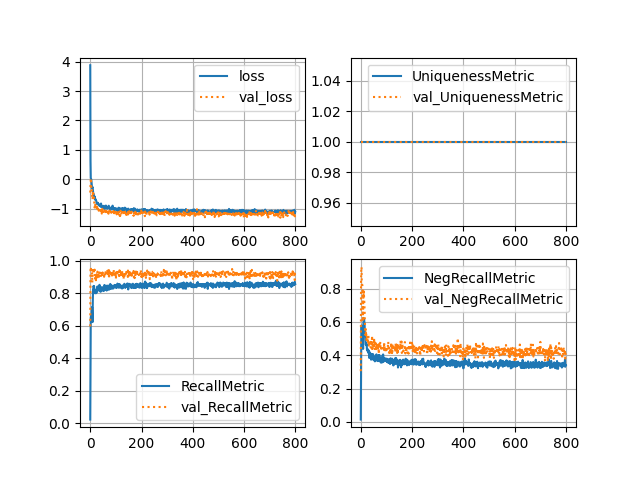

In [8]:
# Plot training history
fig = plt.figure()
lines = [k for k in history.history.keys() if not k.startswith('val_')]
axes = fig.subplots(int(len(lines)/2), 2)
for i in range(len(lines)):
    label = lines[i]
    ax = axes.flatten()[i]
    val_label = 'val_' + label
    ax.plot(history.history[label], label=label)
    if val_label in history.history:
        ax.plot(history.history[val_label], linestyle=':', label=val_label)
        ax.grid()
    ax.legend()